## Road Signs Bounding Box Prediction using Yolo

## 1. Load Data

In [1]:
from pathlib import Path
# set the path
images_path = Path("Data/images")
anno_path = Path("Data/annotations")
images_path, anno_path

(PosixPath('Data/images'), PosixPath('Data/annotations'))

In [2]:
# get a list of image files
image_path_list = list(images_path.glob("*.png"))
image_path_list[:5]

[PosixPath('Data/images/road289.png'),
 PosixPath('Data/images/road504.png'),
 PosixPath('Data/images/road262.png'),
 PosixPath('Data/images/road276.png'),
 PosixPath('Data/images/road510.png')]

In [3]:
# get a list of .xml files
anno_path_list = list(anno_path.glob("*.xml"))
anno_path_list[:5]

[PosixPath('Data/annotations/road712.xml'),
 PosixPath('Data/annotations/road706.xml'),
 PosixPath('Data/annotations/road289.xml'),
 PosixPath('Data/annotations/road538.xml'),
 PosixPath('Data/annotations/road510.xml')]

### 1.1 Check the info of the bounding box

In [4]:
# trying to load the annotation information
import xml.etree.ElementTree as ET

filepath = Path("Data/annotations/road207.xml")
# pick a single example
print(f"Name of .xml file: {filepath}")
root = ET.parse(filepath).getroot()
print("Corresponding image file:", Path(str(images_path) + '/'+ root.find("./filename").text))
print("Image width:", root.find("./size/width").text)
print("Image height:", root.find("./size/height").text)

for obj in root.iter('object'):
    print("Object name:", obj.find("name").text)
    print("xmin:", obj.find("bndbox/xmin").text)
    print("ymin:", obj.find("bndbox/ymin").text)

Name of .xml file: Data/annotations/road207.xml
Corresponding image file: Data/images/road207.png
Image width: 300
Image height: 400
Object name: speedlimit
xmin: 176
ymin: 184
Object name: crosswalk
xmin: 33
ymin: 214


### 1.2 Label Encode the class names

In [5]:
# label encode the class names
class_dict = {
    "speedlimit" : 0,
    "stop": 1,
    "crosswalk": 2,
    "trafficlight": 3
}

## 2. Split Data into train and test sets and Augment images

### 2.1 Create train and test folders

In [6]:
# create train and test folder
import os
train_path = Path("Data/train")
test_path = Path("Data/test")
os.makedirs(train_path, exist_ok = True)
os.makedirs(test_path, exist_ok = True)

img_train = os.path.join(train_path, "images")
anno_train = os.path.join(train_path, "labels")
img_test = os.path.join(test_path, "images")
anno_test = os.path.join(test_path, "labels")

os.makedirs(img_train, exist_ok = True)
os.makedirs(anno_train, exist_ok = True)
os.makedirs(img_test, exist_ok = True)
os.makedirs(anno_test, exist_ok = True)

In [7]:
# split the data image into train and test sets
from math import floor
import random

def get_train_test_sets(file_list):
    random.shuffle(file_list)
    split = 0.8     # 0.8 train, 0.2 test
    split_index = floor(len(file_list) * split)
    training = file_list[:split_index]
    testing = file_list[split_index:]
    return training, testing

In [8]:
train_list, test_list = get_train_test_sets(image_path_list)
train_list[:2], test_list[:2]

([PosixPath('Data/images/road72.png'), PosixPath('Data/images/road44.png')],
 [PosixPath('Data/images/road354.png'), PosixPath('Data/images/road473.png')])

### 2.2 Create helper functions

In [9]:
import albumentations as A

def augmentation(img, bboxes):
    """ function to do data augmentation on the given list of bboox """
    transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.3),
        A.HueSaturationValue(p=0.3),
        A.RGBShift(p=0.3),
        A.MultiplicativeNoise(multiplier=[0.5, 1.5], per_channel=True, p=0.2)
    ], bbox_params=A.BboxParams(format='yolo'))

    transformed = transform(image=img, bboxes=bboxes)
    transformed_image = transformed['image']
    transformed_bboxes = transformed['bboxes']
    return (transformed_image, transformed_bboxes)

In [10]:
def convert_xml_to_txt(filepath):
    """ read the .xml file and return the info """
    root = ET.parse(filepath).getroot()
    # find attributes
    objs = []
    W = int(root.find("./size/width").text)
    H = int(root.find("./size/height").text)

    for obj in root.iter('object'):
        class_name = obj.find("name").text
        label = class_dict[class_name]
        xmin = int(obj.find("bndbox/xmin").text)
        ymin = int(obj.find("bndbox/ymin").text)
        xmax = int(obj.find("bndbox/xmax").text)
        ymax = int(obj.find("bndbox/ymax").text)
        objs.append([label, xmin, ymin, xmax, ymax])

    return (W, H, objs)

In [11]:
import pybboxes as pbx
from PIL import Image
import cv2

def convert_and_aug(file_path, img_path, txt_file_path, aug_img_path, aug_label_path):
    """
    1. extract the info from .xml file
    2. convert to yolo format
    3. do augmentation
    4. write the transformed image and transformed label to destination path
    """
    img = cv2.imread(img_path)
    
    # extract the info from .xml file
    W, H, bboxes = convert_xml_to_txt(file_path)

    # convert to yolo format
    write_str = ""
    yolobbs = []
    for voc_bbox in bboxes:
        label = voc_bbox[0]
        x, y, w, h = pbx.convert_bbox(voc_bbox[1:], from_type="voc", to_type="yolo", image_size=(W,H))
        write_str += str(label) + " " + str(x) + " " + str(y) + " " + str(w) + " " + str(h) + "\n"
        yolobbs.append([x, y, w, h, label])

    # write the original yolo format to .txt file
    with open(txt_file_path, 'w') as f:
        f.write(write_str)
    f.close()

    # do augmentation
    trans_img, trans_bb = augmentation(img, yolobbs)

    # save the transformed image and transformed bbox into files
    write_str = ""
    W, H = int(trans_img.shape[1]), int(trans_img.shape[0])
    for bb in trans_bb:
        x, y, w, h, label = bb
        write_str += str(label) + " " + str(x) + " " + str(y) + " " + str(w) + " " + str(h) + "\n"

    # write into a new file
    f = open(aug_label_path, "w")
    f.write(write_str)
    f.close()
    cv2.imwrite(aug_img_path, trans_img)

### 2.3 put all together

**1. Transform images and bounding boxes**

**2. Save into new folders**

In [12]:
import shutil
import re

# train
img_from = 'Data/images/'
anno_from = 'Data/annotations/'

img_dst = 'Data/train/images/'
anno_dst = 'Data/train/labels/'

for f in train_list:
    im = "road" + str((re.findall(r'\d+', str(f)))[0])
    train_img_from = img_from + im + ".png"
    train_img_to = img_dst + im + ".png"
    aug_img_to = img_dst + im + "_aug.png"

    train_anno_from = anno_from + im + ".xml"
    train_anno_to = anno_dst + im + ".txt"
    aug_anno_to = anno_dst + im + "_aug.txt"

    shutil.copy(train_img_from, train_img_to)
    convert_and_aug(train_anno_from, train_img_to, train_anno_to, aug_img_to, aug_anno_to)

In [13]:
# test
img_from = 'Data/images/'
anno_from = 'Data/annotations/'

img_dst = 'Data/test/images/'
anno_dst = 'Data/test/labels/'

for f in test_list:
    im = "road" + str((re.findall(r'\d+', str(f)))[0])
    test_img_from = img_from + im + ".png"
    test_img_to = img_dst + im + ".png"
    aug_img_to = img_dst + im + "_aug.png"

    test_anno_from = anno_from + im + ".xml"
    test_anno_to = anno_dst + im + ".txt"
    aug_anno_to = anno_dst + im + "_aug.txt"

    shutil.copy(test_img_from, test_img_to)
    convert_and_aug(test_anno_from, test_img_to, test_anno_to, aug_img_to, aug_anno_to)

## 3. Visualize images with its bounding boxes

In [14]:
def plot_box(image, bboxes):
    """ Function to plot the image with bounding box """
    # plt.imshow(img)
    for bb in bboxes:
        xmin, ymin, xmax, ymax = int(bb[0]), int(bb[1]), int(bb[2]), int(bb[3])
        cv2.rectangle(
                image, 
                (xmin, ymin), (xmax, ymax),
                color=(0, 0, 255),
            )
    return image

In [15]:
# Function to convert bounding boxes in YOLO format to xmin, ymin, xmax, ymax.
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

In [16]:
import glob
import matplotlib.pyplot as plt
import random

# Function to plot images with the bounding boxes.
def plot(image_paths, label_paths, num_samples):
    all_images = []
    all_images.extend(glob.glob(image_paths+'/*_aug.png'))

    all_images.sort()
    num_images = len(all_images)

    plt.figure(figsize=(8, 8))
    for i in range(num_samples):
        j = random.randint(0, num_images-1)
        image_name = all_images[j]
        image_name = '.'.join(image_name.split(os.path.sep)[-1].split('.')[:-1])
        image = cv2.imread(all_images[j])
        W, H = int(image.shape[1]), int(image.shape[0])
        with open(os.path.join(label_paths, image_name+'.txt'), 'r') as f:
            bboxes = []
            label_lines = f.readlines()
            for label_line in label_lines:
                bbox_string = label_line[2:]
                x, y, w, h = bbox_string.split(' ')
                x1, y1, x2, y2 = yolo2bbox([float(x), float(y), float(w), float(h)])
                x1 = int(x1*W)
                y1 = int(y1*H)
                x2 = int(x2*W)
                y2 = int(y2*H)
                bboxes.append([x1, y1, x2, y2])

        result_image = plot_box(image, bboxes)
        plt.subplot(2, 2, i+1)
        plt.imshow(result_image[:, :, ::-1])
        plt.axis('off')
    plt.subplots_adjust(wspace=1)
    plt.tight_layout()
    plt.show()

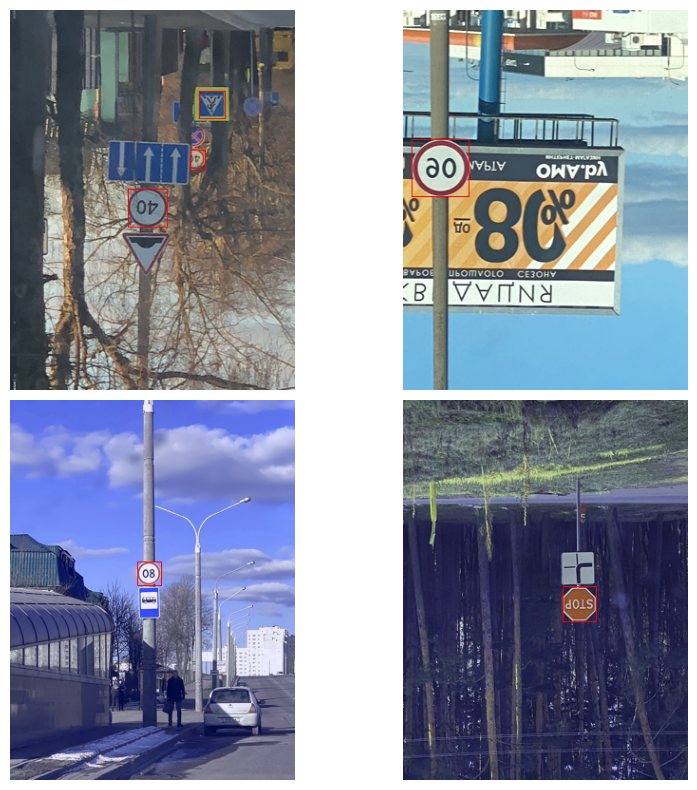

In [17]:
# Visualize a few training images.
plot(
    image_paths='Data/train/images/', 
    label_paths='Data/train/labels/',
    num_samples=4,
)